# Seeing if `climpred` will suit my needs

In [1]:
import glob
import dask

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import climpred # Currently using local forked version (editible)
from climpred import HindcastEnsemble

In [2]:
from src.utils import io
from src.utils import utils

In [3]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = '04:00:00'
cores = 48
memory = '192GB'
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P xv83',
                                '-l jobfs=100GB',
                                '-l storage=gdata/xv83'],
                     local_directory='$PBS_JOBFS',
                     # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
                     header_skip=["select"])

/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.46.39:8787/status,
Dashboard: http://10.6.46.39:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.46.39:40801,Workers: 0
Dashboard: http://10.6.46.39:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Prep some data

### CAFE hindcasts

In [5]:
data_dir = '/g/data/xv83/dcfp/CAFE-f6'
realm = 'atmos_isobaric_month.zarr.zip'

files = sorted(glob.glob(f'{data_dir}/c5-d60-pX-f6-*/{realm}'))

In [6]:
def preprocess_CAFEf6(ds):
    """ Preprocessing steps for CAFE-f6 data """
    ds = utils.convert_time_to_lead(ds)
    ds = utils.truncate_latitudes(ds)
    return ds

cafe_hcst = io.open_mfzarr(
    files, preprocess=preprocess_CAFEf6, parallel=False)['t_surf']

cafe_hcst = cafe_hcst.rename({'ensemble': 'member'}) # Req by climpred
cafe_hcst['lead'].attrs['units'] = 'months' # Req by climpred
cafe_hcst = cafe_hcst.drop('time') # Req by climpred

cafe_hcst = utils.round_to_start_of_month(cafe_hcst, dim='init')

### CAFE historical

In [7]:
data_dir = '/g/data/xv83/users/ds0092/data/CAFE/historical/WIP'
realm = 'atmos_isobaric_month.zarr.zip'

In [8]:
cafe_hist = utils.truncate_latitudes(
    xr.open_zarr(f'{data_dir}/c5-d60-pX-hist-19601101/ZARR/{realm}'))['t_surf']
cafe_ctrl = utils.truncate_latitudes(
    xr.open_zarr(f'{data_dir}/c5-d60-pX-ctrl-19601101/ZARR/{realm}'))['t_surf']

cafe_hist = cafe_hist - cafe_ctrl.mean('ensemble')
cafe_hist = cafe_hist.rename({'ensemble': 'member'}) # Req by climpred

cafe_hist = utils.round_to_start_of_month(cafe_hist, dim='time')

In [178]:
def stack_by_init_date(ds, init_dates, n_lead_steps,
                       time_dim='time', init_dim='init', lead_dim='lead'):
    """ Stack timeseries array in inital date / lead time format.
        Adapted from https://github.com/AusClimateService/unseen/blob/master/unseen
    """
    # Only keep init dates that fall within available times
    
    times = ds[time_dim]  
    # Keep only init_dates that fall within dataset 
    init_dates = init_dates[np.logical_and(init_dates>=times.min(), init_dates<=times.max())]

    time2d = np.empty((len(init_dates), n_lead_steps), 'object')
    time2d[:] = np.nan # Nans where data do not exist
    init_date_indexes = []
    for ndate, init_date in enumerate(init_dates):
        start_index = np.where(times == init_date)[0][0]
        end_index = start_index + n_lead_steps
        time_slice = ds[time_dim][start_index:end_index]
        time2d[ndate, :len(time_slice)] = time_slice
        init_date_indexes.append(start_index)

#     strides = np.diff(init_date_indexes)
#     if np.all(strides == strides[0]): # If step is regular, use stride to reduce memory usage
#         stride = strides[0]
#         ds = ds.isel({time_dim: slice(init_date_indexes[0], init_date_indexes[-1]+stride)})
#         ds = ds.rolling({time_dim: n_lead_steps}, min_periods=1).construct(
#             lead_dim, stride=stride, keep_attrs=True)
#     else:
#         ds = ds.rolling({time_dim: n_lead_steps}, min_periods=1).construct(
#             lead_dim, keep_attrs=True)
#         print(ds)
#         ds = ds.isel({time_dim: init_date_indexes})
        
#     ds = ds.rename({time_dim: init_dim})
#     ds = ds.assign_coords({lead_dim: ds[lead_dim].values})
#     ds = ds.assign_coords({init_dim: time2d[:, 0]})
#     ds = ds.assign_coords({time_dim: ([init_dim, lead_dim], time2d)})
    
    return ds

In [68]:
test = stack_by_init_date(
    cafe_hist.chunk({'time': -1, 'member': 1}), 
    init_dates=cafe_hcst.init, 
    n_lead_steps=len(cafe_hcst.lead))

In [69]:
time = xr.cftime_range(start='2000-01-01', end='2010-12-31', freq='D')
data = np.array([t.toordinal() for t in time])
data = xr.DataArray(data - data[0], coords={'time': time})

In [179]:
init = xr.cftime_range(start='2000-01-01', end='2020-12-31', freq='MS')
test = stack_by_init_date(data,
                   init_dates=init,
                   n_lead_steps=365)

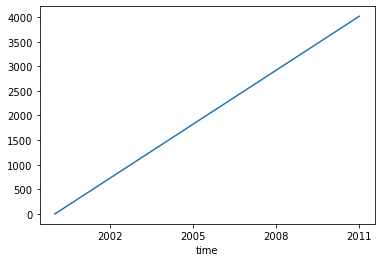

In [189]:
test.plot()

# WHAT ABOUT IF WE FLIP IT?

In [192]:
test.rolling({time_dim: n_lead_steps}, min_periods=1).construct(lead_dim, keep_attrs=True).isel(time=1)

<xarray.DataArray (lead: 365)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,
        1.])
Coordinates:
    time     object 2000-01-02 00:00:00
Dimensions without coordinates: lead

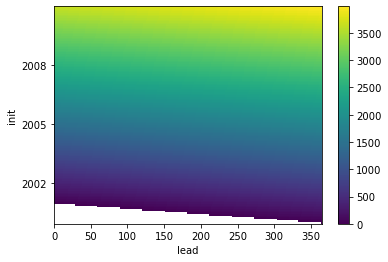

In [168]:
test.plot()

In [165]:
test = test.chunk({'init': 1, 'lead': 24, 'member': -1})

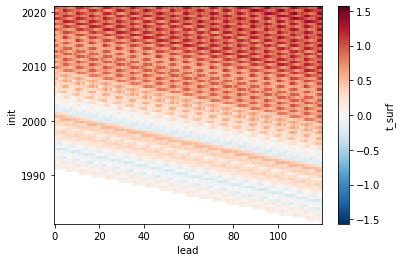

In [12]:
test.mean(['member','lat','lon']).plot()

### JRA55

In [25]:
jra55 = utils.truncate_latitudes(
    xr.open_zarr('/g/data/xv83/reanalyses/JRA55/surface_month_cafe-grid.zarr.zip', use_cftime=True))[['TMP_GDS0_HTGL']]

jra55 = jra55.rename({
    'TMP_GDS0_HTGL': 't_surf',
    'initial_time0_hours': 'time'})
jra55 = jra55.assign_coords({'time': xr.cftime_range(
    start=jra55.time[0].item().strftime(), 
    end=jra55.time[-1].item().strftime(), freq='MS', calendar="julian")}) # Force to Julian calendar

# Play with `climpred`

In [29]:
hindcast = HindcastEnsemble(cafe_hcst.chunk({'init': -1, 'lon': 6}))
hindcast = hindcast.add_uninitialized(cafe_hist.chunk({'time':-1, 'lon': 6}))
hindcast = hindcast.add_observations(jra55)

In [30]:
hindcast.remove_bias(
    how="additive_mean",
    alignment="same_verifs",
    train_test_split="unfair",
).plot()

CoordinateError: A common set of verification dates cannot be found for the initializations and verification data supplied. Change `alignment` to 'same_inits' or 'maximize'.

In [192]:
acc = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='same_init')

CPU times: user 1.51 s, sys: 91.4 ms, total: 1.6 s
Wall time: 5.93 s


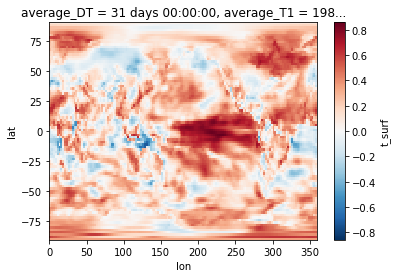

In [200]:
%%time
acc['t_surf'].isel(lead=0).plot()

In [196]:
cafe_hcst

<xarray.DataArray 't_surf' (init: 80, lead: 120, member: 96, lat: 90, lon: 144)>
dask.array<concatenate, shape=(80, 120, 96, 90, 144), dtype=float32, chunksize=(1, 24, 96, 90, 144), chunktype=numpy.ndarray>
Coordinates:
    area        (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
    average_DT  (lead) timedelta64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    average_T1  (lead) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    average_T2  (lead) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * member      (member) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lead        (lead) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
    zsurf       (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
  * init        (init) object 1981-05-16 12:00:00 ... 2020-11-16 00:00:00
Attributes:
    cell_methods:   time: mean
    long_name:      surface temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          deg_k
    valid_range:    [100.0, 400.0]